In [248]:
import pandas as pd
import decimal as dc
%matplotlib inline
"""
处理中烟实际运行线路数据
"""
dc.getcontext().rounding = dc.ROUND_HALF_UP
matrix_id = pd.read_csv("data/mapping", names=['id', 'lat', 'lng'])
matrix_id[['lng', 'lat']] = matrix_id[['lng', 'lat']].astype(str)
matrix_id = matrix_id.set_index(['lng', 'lat'])

matrix = pd.read_csv("data/matrix", names=['order', 'from_id', 'to_id', 'distance', 'time']).set_index(['from_id', 'to_id'])
distance, time = matrix.loc[9723, 9722][['distance', 'time']]

data = pd.read_excel("data/zhongyan_current_res.xlsx")
data.drop(['装货体积（方）', '要求装货时间', '要求送达时间'],axis=1, inplace=True)
data.rename(columns=
    {'订单ID':'orderId',
    '经度':'lng',
    '纬度':'lat',
    '送货路线':'route',
    '装货重量（吨）':'weight'}, inplace=True)
data = data.groupby('route')
# print(data.count())
statistic = {}
depot_lng = '117.273733'
depot_lat = '31.787423'
depot_id = matrix_id.loc[depot_lng, depot_lat]['id']


for name, group in data:
    last_id = depot_id
    route_transport_time = 0
    route_distance = 0
    
    for i in range(len(group) - 1):
        cur_lng = str(group.iloc[i]['lng'])
        cur_lat = str(group.iloc[i]['lat'])
        cur_id = matrix_id.loc[cur_lng, cur_lat]['id']
        res = (0, 0)
        try:
            if(last_id != cur_id):
                res = matrix.loc[last_id, cur_id][['time', 'distance']]
        except KeyError:
            res = matrix.loc[cur_id, last_id][['time', 'distance']]
#         print(res)
        route_transport_time += res[0]
        # 卸货时间，单位秒
        route_transport_time += 180
        route_distance += res[1]
        last_id = cur_id
    ## 回仓
    res = (0, 0)
    try:
        if(last_id != depot_id):
            res = matrix.loc[last_id, depot_id][['time', 'distance']]
    except KeyError:
        res = matrix.loc[depot_id, last_id][['time', 'distance']]
    route_transport_time += res[0]
    route_distance += res[1]
    statistic[name] = {'time': dc.Decimal(route_transport_time / 60, dc.getcontext()).__round__(0),
                       'distance': dc.Decimal(route_distance / 1000, dc.getcontext()).__round__(0)}
    
current_res = pd.DataFrame(statistic)
# current_res['总计'] = current_res.sum(axis=1)
current_res



,线路01,线路02,线路03,线路04,线路05,线路06,线路07,线路08,线路09,线路10,线路11,线路12,线路13,线路14,线路15
distance,282,365,230,209,276,257,307,210,328,232,425,181,216,239,213
time,715,843,626,555,683,663,742,540,862,647,1013,508,613,650,627


In [249]:

"""
统计Jsprit输出方案(时间均衡版）的距离与时间
"""
def transform(timeStr):
    return int(timeStr.split(":")[0]) * 60 + int(timeStr.split(":")[1]) - 8 * 60

data = pd.read_excel("data/zhongyan_balanced_res.xls", header=None, names=['route', 'vehicleType', 'type', 'orderId', 'arrTime', 'endTime', 'distance', 'cost'])
data.dropna(axis=0, how='all', inplace=True)
data = data.groupby('route')

statistic = {}
for name, group in data:
    statistic["路线%.2d" % name] = {"distance": group.iloc[-1]['distance'] / 1000, "time": transform(group.iloc[-1]['endTime'])}
    
balanced_res = pd.DataFrame(statistic)
# balanced_res['总计'] = balanced_res.sum(axis=1)
balanced_res



,路线01,路线02,路线03,路线04,路线05,路线06,路线07,路线08,路线09,路线10,路线11,路线12,路线13,路线14,路线15
distance,247.169,278.282,194.78,271.758,260.282,228.51,243.45,242.857,230.001,245.583,239.531,233.576,231.985,233.464,252.601
time,630.000,630.000,615.00,630.000,627.000,630.00,630.00,629.000,621.000,629.000,629.000,629.000,630.000,624.000,626.000


In [250]:
"""
统计Jsprit输出方案(总成本最小版）的距离与时间
"""
def transform(timeStr):
    return int(timeStr.split(":")[0]) * 60 + int(timeStr.split(":")[1]) - 8 * 60

data = pd.read_excel("data/zhongyan_min_cost_res.xls", header=None, names=['route', 'vehicleType', 'type', 'orderId', 'arrTime', 'endTime', 'distance', 'cost'])

data.dropna(axis=0, how='all', inplace=True)

data = data.groupby('route')

statistic = {}
for name, group in data:
    statistic["路线%.2d" % name] = {"distance": group.iloc[-1]['distance'], "time": transform(group.iloc[-1]['endTime'])}
    
min_cost_res = pd.DataFrame(statistic)
# min_cost_res['总计'] = min_cost_res.sum(axis=1)
min_cost_res

,路线01,路线02,路线03,路线04,路线05,路线06,路线07,路线08,路线09,路线10,路线11,路线12,路线13,路线14
distance,183.0,176.0,169.0,192.0,192.0,163.0,167.0,170.0,208.0,161.0,159.0,135.0,130.0,154.0
time,630.0,630.0,543.0,630.0,629.0,573.0,579.0,623.0,624.0,606.0,530.0,366.0,464.0,385.0


505
[0.08535044230582288, 0.24059492563429571]


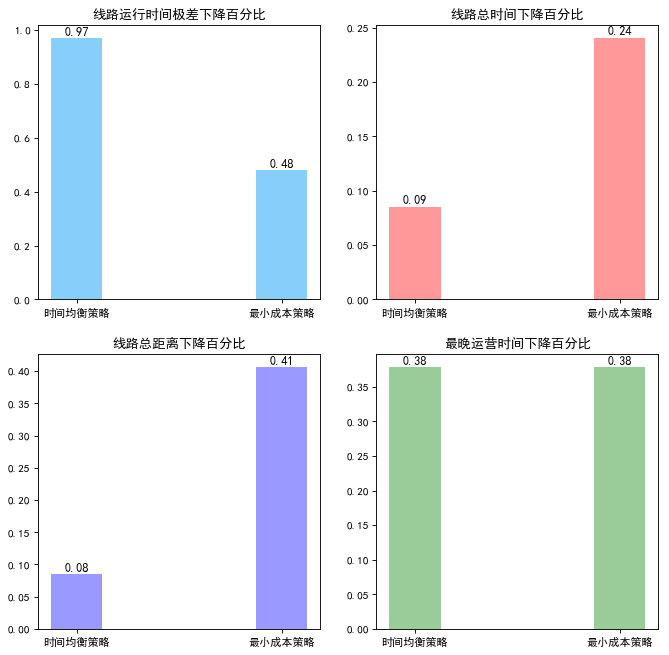

In [316]:
"""
统计图
"""
import matplotlib.pyplot as plt
import numpy as np

figure_1 = plt.figure(figsize=(10,10), dpi=80)
opacity = 0.4

# 运行时间极差下降百分比
current_time_range = current_res.loc['time'].max() - current_res.loc['time'].min()
print(current_time_range)
balance_time_range_improved =(current_time_range - dc.Decimal(balanced_res.loc['time'].max() - balanced_res.loc['time'].min())) \
    / current_time_range
minCost_time_range_improved = (current_time_range - dc.Decimal(min_cost_res.loc['time'].max() - min_cost_res.loc['time'].min())) \
    / current_time_range
    
# 最晚运营时间下降百分比
current_max_time = float(current_res.loc['time'].max())
balance_max_time_improved = (current_max_time - balanced_res.loc['time'].max()) / current_max_time
minCost_max_time_improved = (current_max_time - min_cost_res.loc['time'].max()) / current_max_time

# 总运行时间下降百分比
current_total_time  = float(current_res.loc['time'].sum())
balanced_total_time_improved = (current_total_time - balanced_res.loc['time'].sum()) / current_total_time
minCost_total_time_improved = (current_total_time - min_cost_res.loc['time'].sum()) / current_total_time
    
# 总距离下降百分比
current_total_distance = float(current_res.loc['distance'].sum())
balanced_total_distance_improved = (current_total_distance - balanced_res.loc['distance'].sum()) / current_total_distance
minCost_total_distance_improved = (current_total_distance - min_cost_res.loc['distance'].sum()) / current_total_distance
    
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

plt.subplot(2,2,1)
range_list = [float(balance_time_range_improved.__round__(2)), float(minCost_time_range_improved.__round__(2))]
plt.bar(np.arange(2), range_list, 0.25,color="#87CEFA", tick_label=['时间均衡策略', '最小成本策略'])
for a,b in zip(np.arange(2), range_list):
    plt.text(a, b+0.001, '%.2f' % b, ha='center', va= 'bottom',fontsize=11)
plt.title(u"线路运行时间极差下降百分比")

plt.subplot(2,2,2)
totalTime_list = [balanced_total_time_improved, minCost_total_time_improved]
print(totalTime_list)
plt.bar(np.arange(2), totalTime_list, 0.25,alpha=opacity, color="red", tick_label=['时间均衡策略', '最小成本策略'])
for a,b in zip(np.arange(2), totalTime_list):
    plt.text(a, b+0.001, '%.2f' % b, ha='center', va= 'bottom',fontsize=11)
plt.title("线路总时间下降百分比")

plt.subplot(223)
totalDistance_list = [balanced_total_distance_improved, minCost_total_distance_improved]
plt.bar(np.arange(2), totalDistance_list, 0.25, alpha=opacity, color='b', tick_label=['时间均衡策略', '最小成本策略'])
for a,b in zip(np.arange(2), totalDistance_list):
    plt.text(a, b+0.001, '%.2f' % b, ha='center', va= 'bottom',fontsize=11)
plt.title("线路总距离下降百分比")

plt.subplot(224)
totalMaxtime_list = [balance_max_time_improved, minCost_max_time_improved]
plt.bar(np.arange(2), totalMaxtime_list, 0.25, alpha=opacity, color='green', tick_label=['时间均衡策略', '最小成本策略'])
for a, b in zip(np.arange(2), totalMaxtime_list):
    plt.text(a, b+0.001, '%.2f' % b, ha='center', va='bottom', fontsize=11)
plt.title("最晚运营时间下降百分比")